# Section 1: Setup and Imports

This section initializes the environment, imports required libraries, and sets up paths and devices for training the GraphSAGE model.

In [1]:
# Cell 1: Imports and environment setup

import os
import sys
import torch
import torch.nn.functional as F
from collections import Counter
from sklearn.model_selection import train_test_split

# Ensure the src folder is on the path
sys.path.append(os.path.abspath(".."))

# Custom modules
from src.data_utils import load_and_preprocess_elliptic_data
from src.model_sage import GraphSAGENet
from src.train_sage import train, evaluate

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
model_dir = "../models/GraphSAGE"
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, "best_model.pth")
epoch_tracker_path = os.path.join(model_dir, "epoch_counter.txt")


Using device: cpu


# Section 2: Load and Preprocess Data

We load the full transaction graph using a pre-built utility. This handles:
- Mapping transaction IDs to node indices
- Assigning class labels
- Normalizing features
- Removing isolated nodes

In [2]:
# Cell 2: Load and preprocess the dataset

data = load_and_preprocess_elliptic_data()
print(data)

# Confirm class label distribution
label_mask = data.y != -1
print("Labeled class distribution:", Counter(data.y[label_mask].tolist()))


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])
Labeled class distribution: Counter({1: 42019, 0: 4545})


# Section 3: Train/Validation Split

Split the labeled nodes into stratified training and validation sets to ensure balanced class representation across both subsets.

In [3]:
# Cell 3: Create stratified train/val split

import numpy as np
from sklearn.model_selection import train_test_split

# Only include nodes with known labels
labeled_indices = torch.where(data.y != -1)[0]
labels = data.y[labeled_indices].cpu().numpy()

train_idx, val_idx = train_test_split(
    labeled_indices.cpu().numpy(),
    test_size=0.3,
    random_state=42,
    stratify=labels
)

# Move indices to device
train_idx = torch.tensor(train_idx, dtype=torch.long).to(device)
val_idx = torch.tensor(val_idx, dtype=torch.long).to(device)

# Show class distributions
print("Train class balance:", Counter(data.y[train_idx].cpu().numpy()))
print("Val class balance:", Counter(data.y[val_idx].cpu().numpy()))


Train class balance: Counter({np.int64(1): 29413, np.int64(0): 3181})
Val class balance: Counter({np.int64(1): 12606, np.int64(0): 1364})


# Section 4: Initialize the GraphSAGE Model

We instantiate the GraphSAGENet model defined in `src/model_sage.py`. It consists of two GraphSAGE layers with ReLU activation and dropout in between.

In [4]:
# Cell 4: Instantiate the model

model = GraphSAGENet(
    in_channels=data.x.shape[1],
    hidden_channels=16,
    out_channels=2,
    dropout=0.3
).to(device)

print(model)

GraphSAGENet(
  (conv1): SAGEConv(166, 16, aggr=mean)
  (conv2): SAGEConv(16, 2, aggr=mean)
)


# Section 5: Train GraphSAGE with Early Stopping

Train the GraphSAGE model with early stopping, learning rate scheduling, and epoch tracking. The best model (by validation accuracy) is saved to disk.


In [5]:
# Cell 5: Training loop

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Epoch tracking setup
if os.path.exists(epoch_tracker_path):
    with open(epoch_tracker_path, "r") as f:
        epoch_offset = int(f.read().strip())
        print(f"Continuing from epoch offset: {epoch_offset}")
else:
    epoch_offset = 0
    print("Starting fresh — epoch offset = 0")

num_epochs = 200
patience = 20
best_val_acc = 0
best_epoch = 0
counter = 0
loss_history = []
val_history = []

for epoch in range(num_epochs):
    loss = train(model, data, train_idx, optimizer)
    acc = evaluate(model, data, val_idx)
    scheduler.step(loss)

    loss_history.append(loss)
    val_history.append(acc)

    print(f"Epoch {epoch}: Loss = {loss:.4f}, Val Acc = {acc:.4f}")

    if acc > best_val_acc:
        best_val_acc = acc
        best_epoch = epoch
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"→ Best model saved (Val Acc = {acc:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Save total training epochs
total_epochs = epoch_offset + best_epoch
with open(epoch_tracker_path, "w") as f:
    f.write(str(total_epochs))

print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Total epochs trained so far: {total_epochs}")


Starting fresh — epoch offset = 0
Epoch 0: Loss = 1.0845, Val Acc = 0.2928
→ Best model saved (Val Acc = 0.2928)
Epoch 1: Loss = 0.9820, Val Acc = 0.3481
→ Best model saved (Val Acc = 0.3481)
Epoch 2: Loss = 0.8682, Val Acc = 0.4144
→ Best model saved (Val Acc = 0.4144)
Epoch 3: Loss = 0.7889, Val Acc = 0.4710
→ Best model saved (Val Acc = 0.4710)
Epoch 4: Loss = 0.7316, Val Acc = 0.5200
→ Best model saved (Val Acc = 0.5200)
Epoch 5: Loss = 0.6847, Val Acc = 0.5744
→ Best model saved (Val Acc = 0.5744)
Epoch 6: Loss = 0.6454, Val Acc = 0.6135
→ Best model saved (Val Acc = 0.6135)
Epoch 7: Loss = 0.6106, Val Acc = 0.6462
→ Best model saved (Val Acc = 0.6462)
Epoch 8: Loss = 0.5756, Val Acc = 0.6742
→ Best model saved (Val Acc = 0.6742)
Epoch 9: Loss = 0.5536, Val Acc = 0.6976
→ Best model saved (Val Acc = 0.6976)
Epoch 10: Loss = 0.5307, Val Acc = 0.7168
→ Best model saved (Val Acc = 0.7168)
Epoch 11: Loss = 0.5147, Val Acc = 0.7345
→ Best model saved (Val Acc = 0.7345)
Epoch 12: Loss =

# Section 6: Resume Training from Saved Model (Optional)

Resume training from the last saved best model checkpoint. This supports multi-session training and allows incremental improvements without starting over.

In [6]:
# Cell 6: Resume training

resumed_model = GraphSAGENet(
    in_channels=data.x.shape[1],
    hidden_channels=16,
    out_channels=2,
    dropout=0.3
).to(device)

if os.path.exists(best_model_path):
    resumed_model.load_state_dict(torch.load(best_model_path))
    print("Loaded existing best_model.pth")
else:
    print("No existing model found. Starting from scratch.")

if os.path.exists(epoch_tracker_path):
    with open(epoch_tracker_path, "r") as f:
        resume_epoch_offset = int(f.read().strip())
        print(f"Resuming from total epoch offset: {resume_epoch_offset}")
else:
    resume_epoch_offset = 0
    print("Starting fresh — no epoch history found")

resumed_optimizer = torch.optim.Adam(resumed_model.parameters(), lr=0.001, weight_decay=5e-4)
resumed_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resumed_optimizer, mode='min', factor=0.5, patience=10)

resume_epochs = 100
resume_patience = 20
best_val_acc_resume = 0
resume_best_epoch = 0
patience_counter = 0
loss_history_resume = []
val_history_resume = []

for epoch in range(resume_epochs):
    loss = train(resumed_model, data, train_idx, resumed_optimizer)
    acc = evaluate(resumed_model, data, val_idx)
    resumed_scheduler.step(loss)

    loss_history_resume.append(loss)
    val_history_resume.append(acc)

    print(f"[Resume] Epoch {epoch}: Loss = {loss:.4f}, Val Acc = {acc:.4f}")

    if acc > best_val_acc_resume:
        best_val_acc_resume = acc
        resume_best_epoch = epoch
        patience_counter = 0
        torch.save(resumed_model.state_dict(), best_model_path)
        print(f"→ Best resumed model saved (Val Acc = {acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= resume_patience:
            print("Early stopping (resumed training) triggered.")
            break

total_epochs_trained = resume_epoch_offset + resume_best_epoch
with open(epoch_tracker_path, "w") as f:
    f.write(str(total_epochs_trained))

print(f"Best resumed validation accuracy: {best_val_acc_resume:.4f} at resumed epoch {resume_best_epoch}")
print(f"Total epochs trained across sessions: {total_epochs_trained}")

Loaded existing best_model.pth
Resuming from total epoch offset: 199
[Resume] Epoch 0: Loss = 0.1659, Val Acc = 0.9544
→ Best resumed model saved (Val Acc = 0.9544)
[Resume] Epoch 1: Loss = 0.1644, Val Acc = 0.9548
→ Best resumed model saved (Val Acc = 0.9548)
[Resume] Epoch 2: Loss = 0.1645, Val Acc = 0.9550
→ Best resumed model saved (Val Acc = 0.9550)
[Resume] Epoch 3: Loss = 0.1636, Val Acc = 0.9555
→ Best resumed model saved (Val Acc = 0.9555)
[Resume] Epoch 4: Loss = 0.1620, Val Acc = 0.9562
→ Best resumed model saved (Val Acc = 0.9562)
[Resume] Epoch 5: Loss = 0.1586, Val Acc = 0.9565
→ Best resumed model saved (Val Acc = 0.9565)
[Resume] Epoch 6: Loss = 0.1604, Val Acc = 0.9567
→ Best resumed model saved (Val Acc = 0.9567)
[Resume] Epoch 7: Loss = 0.1590, Val Acc = 0.9572
→ Best resumed model saved (Val Acc = 0.9572)
[Resume] Epoch 8: Loss = 0.1565, Val Acc = 0.9576
→ Best resumed model saved (Val Acc = 0.9576)
[Resume] Epoch 9: Loss = 0.1558, Val Acc = 0.9582
→ Best resumed mo

# Section 7: Final Evaluation (F1, PR AUC, ROC AUC)

Evaluate the final saved GraphSAGE model on the validation set using common classification metrics. This includes F1 score, ROC AUC, PR AUC, and class-wise precision/recall.

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Inference
with torch.no_grad():
    logits = model(data.x.to(device), data.edge_index.to(device))[val_idx]
    preds = logits.argmax(dim=1).cpu()
    probs = torch.exp(logits)[:, 1].cpu()  # Probability of class 1 (illicit)

y_true = data.y[val_idx].cpu()

# Metrics
f1 = f1_score(y_true, preds, average='macro')
roc_auc = roc_auc_score(y_true, probs)
pr_auc = average_precision_score(y_true, probs)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, preds, digits=4))

# Print individual metrics
print(f"F1 Score:     {f1:.4f}")
print(f"ROC AUC:      {roc_auc:.4f}")
print(f"PR AUC:       {pr_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0     0.9344    0.7625    0.8397      1364
           1     0.9748    0.9942    0.9844     12606

    accuracy                         0.9716     13970
   macro avg     0.9546    0.8783    0.9121     13970
weighted avg     0.9709    0.9716    0.9703     13970

F1 Score:     0.9121
ROC AUC:      0.9746
PR AUC:       0.9967


# Section 8: Visualize Training Loss, Accuracy, ROC & PR Curves

Plot training loss and validation accuracy over epochs, as well as the ROC and precision-recall curves for the final model on the validation set.

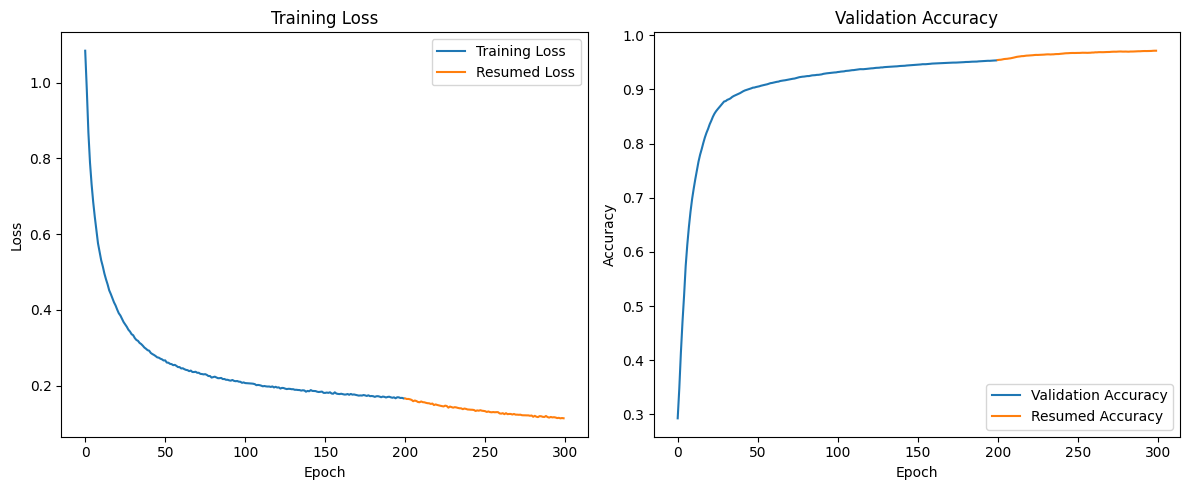

In [8]:
# Cell 8a: Plot training loss and validation accuracy

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Training Loss")
if 'loss_history_resume' in globals():
    plt.plot(range(len(loss_history), len(loss_history) + len(loss_history_resume)), loss_history_resume, label="Resumed Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_history, label="Validation Accuracy")
if 'val_history_resume' in globals():
    plt.plot(range(len(val_history), len(val_history) + len(val_history_resume)), val_history_resume, label="Resumed Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


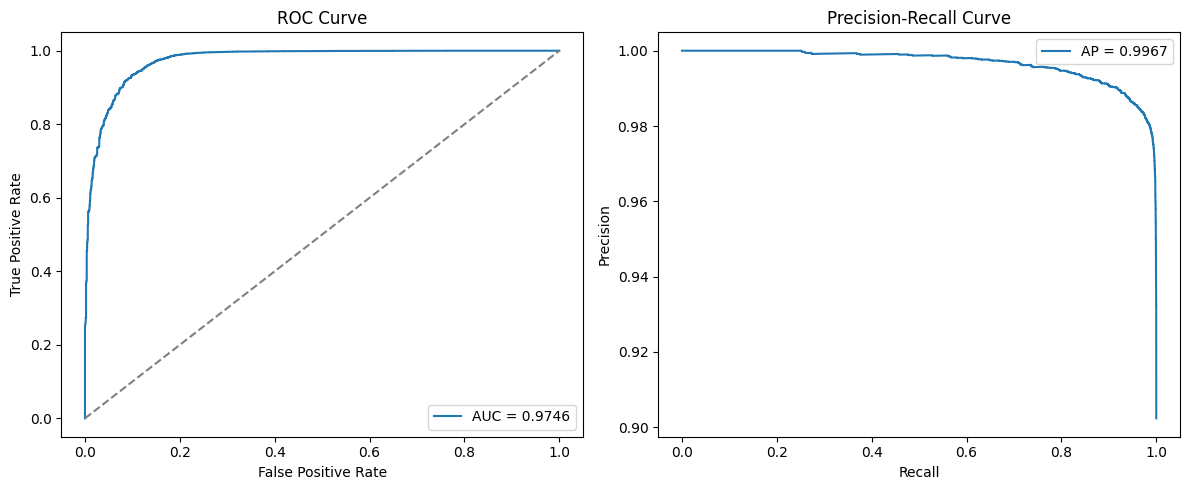

In [9]:
# Cell 8b: ROC and PR curves

from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, probs)
precision, recall, _ = precision_recall_curve(y_true, probs)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()
